In [14]:
from cpp_bag.model import BagPooling
from cpp_bag import data
from pathlib import Path
import torch

In [3]:
DST = Path("data")
MARK = "0"
SPLIT_JSON = DST / f"split{MARK}.json"
WITH_MK = True

In [4]:
all_cells = data.load_cells()
dataset = data.CustomImageDataset(
    data.FEAT_DIR,
    data.LABEL_DIR,
    bag_size=256,
    cell_threshold=300,
    with_MK=WITH_MK,
    all_cells=all_cells,
)
size = len(dataset)
print("size:", size)


slide_portion: [{'Neutrophil': 86, 'Metamyelocyte': 56, 'Erythroblast': 42, 'Myelocyte': 49, 'Lymphocyte': 5, 'Blast': 6, 'Monocyte': 5, 'Promyelocyte': 2, 'Eosinophil': 3, 'Plasma_cell': 1, 'Mast_cell': 1}, {'Monocyte': 25, 'Lymphocyte': 26, 'Neutrophil': 67, 'Erythroblast': 45, 'Metamyelocyte': 33, 'Myelocyte': 39, 'Blast': 14, 'Promyelocyte': 5, 'Histiocyte': 1, 'Plasma_cell': 1}, {'Erythroblast': 153, 'Neutrophil': 21, 'Monocyte': 5, 'Promyelocyte': 7, 'Myelocyte': 21, 'Metamyelocyte': 18, 'Lymphocyte': 7, 'Blast': 18, 'Megakaryocyte_nucleus': 1, 'Histiocyte': 1, 'Eosinophil': 3, 'Plasma_cell': 1}]
D:\DATA\mk_feats\18_0016_AS.json does not exist
D:\DATA\mk_feats\18_0052_AS.json does not exist
D:\DATA\mk_feats\18_0086_AS.json does not exist
D:\DATA\mk_feats\18_0183_AS.json does not exist
D:\DATA\mk_feats\18_0246_AS.json does not exist
D:\DATA\mk_feats\18_0271_AS.json does not exist
D:\DATA\mk_feats\18_0290_AS.json does not exist
D:\DATA\mk_feats\18_0297_AS.json does not exist
D:\DA

In [7]:
import json

with open("data/split.json", "r") as f:
        cache = json.load(f)
        val_indices = cache["val"]
        train_indices = cache["train"]
val_set = data.Subset(dataset, val_indices)
train_set = data.Subset(dataset, train_indices)
in_dim = 256
mp = "pool-1648142022566_MK.pth"
model = BagPooling.from_checkpoint(mp, in_dim=in_dim)

In [21]:
pooling = model.pooling

hopfield_core_forward -> need_weights

attn_output, attn_output_weights, attn_matrix = hopfield_attn(query, key, value)

    - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
              E is the embedding dimension.
    - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
      L is the target sequence length, S is the source sequence length.
    - attn_raw: :math:``(N, num_heads, L, S)`, where N is the batch size,
      L is the target sequence length, S is the source sequence length.

In [66]:
val_cells = val_set.dataset.cells

In [68]:
len(val_cells[0])

5468

In [ ]:
from sklearn.preprocessing import minmax_scale

In [163]:
def att_weight(dataset, index):
    feature, label, sample_cells = dataset.example_samples(dataset , index)    
    input_ = feature.unsqueeze(dim=0)
    attn_raw = pooling.get_association_matrix(input_)
    num_heads = attn_raw.size()[1]
    # average attention weights over heads
    attn_output_weights = attn_raw.sum(dim=1) / num_heads
    
    return attn_output_weights.squeeze()[:len(sample_cells)], sample_cells, label

In [ ]:
import umap
import pandas as pd
import plotly.express as px

reducer = umap.UMAP()

In [328]:
for idx in val_indices:
    attn_output_weights,  sample_cells, label = att_weight(val_set.dataset, idx)
    if label != "acute leukemia":
        continue
    feature = [cell.feature for cell in sample_cells]
    embedding = reducer.fit_transform(feature)
    df = pd.DataFrame(embedding)
    df.columns = ["D1", "D2"]
    df["cellType"] =  [cell.label for cell in sample_cells]
    df["weight"] = minmax_scale(attn_output_weights, (0, 1))
    df["size"] = minmax_scale(attn_output_weights, (0.1, 1))
    df["name"] = [cell.name for cell in sample_cells]
    break

In [143]:
val_set.dataset.le.classes_

array(['acute leukemia', 'lymphoproliferative disorder',
       'myelodysplastic syndrome', 'normal', 'other', 'plasma'],
      dtype='<U28')

In [155]:
TEMPLATE = "plotly_white"
FONT = "Arial"

In [213]:
from PIL import Image, ImageOps

In [186]:
import zipfile

In [187]:
zip_ref = zipfile.ZipFile(Path("D:/DATA/cbp_cell_images.zip"), "r")

In [188]:
from PIL import Image
img_loader = lambda x: Image.open(zip_ref.open(x))

In [196]:
row["name"]

'19_0381_AS.277_10'

In [209]:
import plotly.graph_objects as go


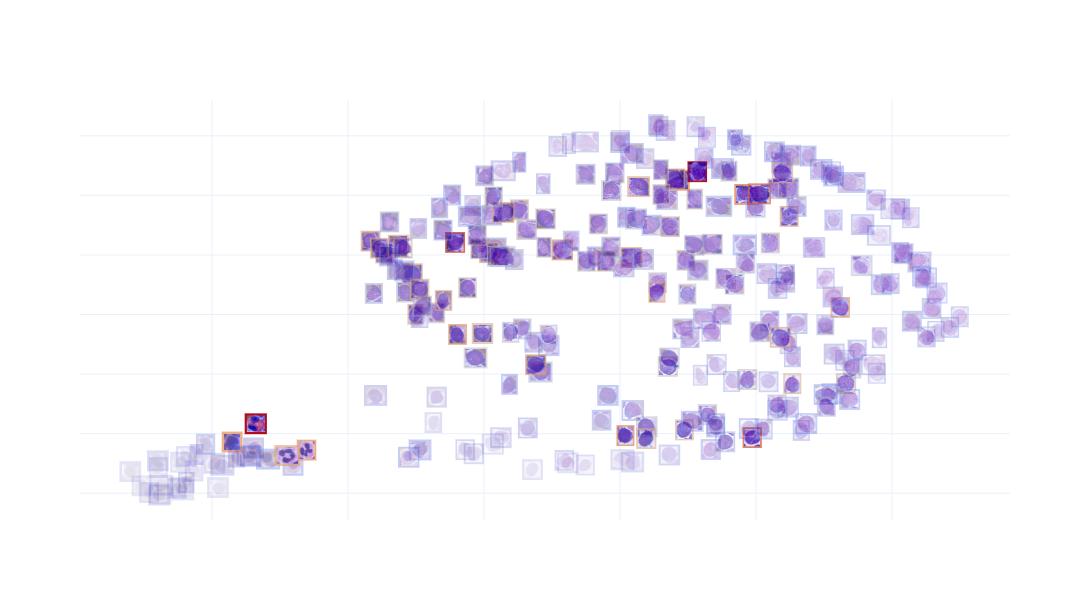

In [329]:
fig = go.Figure()
fig.add_trace(
            go.Scatter(
                mode='markers',
                x=df["D1"],
                y=df["D2"],
                marker=dict(
                    opacity=0,
                ),
                showlegend=False
            )
        )
slide_name = df.iloc[0]["name"].split(".")[0]
for i, row in df.iterrows():
    weight = row["weight"]
    size = row["size"]
    cell_img =img_loader( f"{slide_name}/{row['name']}.jpg")
    color = get_continuous_color(plotly.colors.PLOTLY_SCALES["RdBu"], weight)
    cell_img = ImageOps.expand(cell_img,border=6,fill=color)
    fig.add_layout_image(
        dict(
            source=cell_img,
            xref="x",
            yref="y",
            xanchor="center",
            yanchor="middle",
            x=row["D1"],
            y=row["D2"],
            sizex=0.35,
            sizey=0.35,
            sizing="contain",
            opacity=size,
            layer="above"
        )
    )
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    template=TEMPLATE,
    font_family=FONT,
    legend=dict(
        orientation="h",
    ),
    width=940,
    height=600,
    )

In [304]:
import plotly.colors

def get_continuous_color(colorscale, intermed):
    """
    Plotly continuous colorscales assign colors to the range [0, 1]. This function computes the intermediate
    color for any value in that range.

    Plotly doesn't make the colorscales directly accessible in a common format.
    Some are ready to use:
    
        colorscale = plotly.colors.PLOTLY_SCALES["Greens"]

    Others are just swatches that need to be constructed into a colorscale:

        viridis_colors, scale = plotly.colors.convert_colors_to_same_type(plotly.colors.sequential.Viridis)
        colorscale = plotly.colors.make_colorscale(viridis_colors, scale=scale)

    :param colorscale: A plotly continuous colorscale defined with RGB string colors.
    :param intermed: value in the range [0, 1]
    :return: color in rgb string format
    :rtype: str
    """
    if len(colorscale) < 1:
        raise ValueError("colorscale must have at least one color")

    if intermed <= 0 or len(colorscale) == 1:
        return colorscale[0][1]
    if intermed >= 1:
        return colorscale[-1][1]

    for cutoff, color in colorscale:
        if intermed > cutoff:
            low_cutoff, low_color = cutoff, color
        else:
            high_cutoff, high_color = cutoff, color
            break

    # noinspection PyUnboundLocalVariable
    color_str = plotly.colors.find_intermediate_color(
        lowcolor=low_color, highcolor=high_color,
        intermed=((intermed - low_cutoff) / (high_cutoff - low_cutoff)),
        colortype="rgb")
    return tuple(int(float(f)) for f in re.findall(r'\d+.\d+', color_str))

In [277]:
color = get_continuous_color(plotly.colors.PLOTLY_SCALES["Blues"], 0.1)

rgb(40.0, 60.0, 190.0)


In [265]:
color

(223, 222, 219)

In [234]:
import re

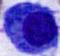

In [214]:
cell_img

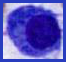

In [278]:
ImageOps.expand(cell_img,border=3,fill=color)

In [181]:
cell_images = {cells[0].name.split(".")[0]:[cell.name for cell in cells] for idx, cells in enumerate(dataset.cells)}

In [182]:
with open("cbp_cell_images.json", "w", encoding="utf8") as target:
    json.dump(cell_images, target)

In [93]:
def example_samples(self, idx):
    label = self.targets[idx]
    slide_portion = self.slide_portion[idx]
    group = self.cell_groups[idx]
    sample_indices = self._sample_idx(slide_portion, group)
    cells = self.cells[idx]
    sample_cells =[cells[i] for i in sample_indices]
    # sample_cell_labels = [sample_cells[i].label for i in sample_indices]
    feature_bag = torch.index_select(
        self._get_features_by_idx(idx),
        0,
        torch.as_tensor(sample_indices),
    )
    if self.with_MK:
        feature = torch.cat([feature_bag, self.MK_features[idx]], dim=0)
    else:
        feature = feature_bag
    return feature,self.le.inverse_transform([label])[0] , sample_cells
val_set.dataset.example_samples = example_samples

In [337]:
from typing import Callable, List
import zipfile
from cpp_bag.model import BagPooling
from cpp_bag import data
from pathlib import Path
import torch
import json
from sklearn.preprocessing import minmax_scale
import umap
import pandas as pd
import plotly.express as px
from hflayers import  HopfieldPooling
import plotly.graph_objects as go
from PIL import Image, ImageOps
import re
import plotly.colors

TEMPLATE = "plotly_white"
FONT = "Arial"

class AttentionWeightPlotter:
    def __init__(self, mp = "pool-1648142022566_MK.pth"):
        self.reducer = umap.UMAP()
        in_dim = 256
        model = BagPooling.from_checkpoint(mp, in_dim=in_dim)
        self.pooling = model.pooling

    def make_att_df(self, cell_bag:List[data.CellInstance], feature_bag: torch.Tensor):
        feature = [cell.feature for cell in cell_bag]
        embedding = self.reducer.fit_transform(feature)
        df = pd.DataFrame(embedding)
        df.columns = ["D1", "D2"]
        df["cellType"] =  [cell.label for cell in cell_bag]
        attn_output_weights = self._attention_weight(feature_bag)[:len(cell_bag)]
        print(attn_output_weights)
        df["weight"] = minmax_scale(attn_output_weights, (0, 1))
        df["size"] = minmax_scale(attn_output_weights, (0.1, 1))
        df["name"] = [cell.name for cell in feature_bag]
        return df
    
    def plot_on_df(self, df: pd.DataFrame, save_path: Path , img_loader: Callable[[str], Image.Image], marker=None ):
        fig = go.Figure()
        fig.add_trace(
                    go.Scatter(
                        mode='markers',
                        x=df["D1"],
                        y=df["D2"],
                        marker=dict(
                            opacity=0,
                        ),
                        showlegend=False
                    )
                )
        slide_name = df.iloc[0]["name"].split(".")[0]
        for i, row in df.iterrows():
            weight = row["weight"]
            size = row["size"]
            cell_img =img_loader( f"{slide_name}/{row['name']}.jpg")
            color = get_continuous_color(plotly.colors.PLOTLY_SCALES["RdBu"], weight)
            cell_img = ImageOps.expand(cell_img,border=6,fill=color)
            fig.add_layout_image(
                dict(
                    source=cell_img,
                    xref="x",
                    yref="y",
                    xanchor="center",
                    yanchor="middle",
                    x=row["D1"],
                    y=row["D2"],
                    sizex=0.35,
                    sizey=0.35,
                    sizing="contain",
                    opacity=size,
                    layer="above"
                )
            )
        fig.update_xaxes(showticklabels=False)
        fig.update_yaxes(showticklabels=False)
        fig.update_layout(
            template=TEMPLATE,
            font_family=FONT,
            legend=dict(
                orientation="h",
            ),
            width=940,
            height=600,
            )
        if marker is not None:
            # fig.write_image(save_path/ f"{slide_name}-{marker}.att.pdf", format="pdf")
            fig.write_image(save_path/ f"{slide_name}-{marker}.att.jpg", format="jpg", scale=3)

        fig.write_image(save_path/ f"{slide_name}.att.jpg", format="jpg",scale=3)
        
        
    def _attention_weight(self, feature: torch.Tensor):
        input_ = feature.unsqueeze(dim=0)
        attn_raw = self.pooling.get_association_matrix(input_)
        num_heads = attn_raw.size()[1]
        # average attention weights over heads
        attn_output_weights = attn_raw.sum(dim=1) / num_heads
        return attn_output_weights
    
def main():
    WITH_MK = True
    all_cells = data.load_cells()
    dataset = data.CustomImageDataset(
        data.FEAT_DIR,
        data.LABEL_DIR,
        bag_size=256,
        cell_threshold=300,
        with_MK=WITH_MK,
        all_cells=all_cells,
    )
    size = len(dataset)
    print("size:", size)
    
    with open("data/split.json", "r") as f:
        cache = json.load(f)
        val_indices = cache["val"]
        # train_indices = cache["train"]
    # val_set = data.Subset(dataset, val_indices)
    # train_set = data.Subset(dataset, train_indices)
    
    att_plotter = AttentionWeightPlotter()
    zip_ref = zipfile.ZipFile(Path("D:/DATA/cbp_cell_images.zip"), "r")
    # open image from zip file
    img_loader = lambda x: Image.open(zip_ref.open(x))
    for index in val_indices:
        feature, label, sample_cells = dataset.example_samples(index)
        df = att_plotter.make_att_df(sample_cells, feature)
        att_plotter.plot_on_df(df, Path("data/att"), img_loader, marker=label)


def get_continuous_color(colorscale, intermed):
    """
    Plotly continuous colorscales assign colors to the range [0, 1]. This function computes the intermediate
    color for any value in that range.

    Plotly doesn't make the colorscales directly accessible in a common format.
    Some are ready to use:
    
        colorscale = plotly.colors.PLOTLY_SCALES["Greens"]

    Others are just swatches that need to be constructed into a colorscale:

        viridis_colors, scale = plotly.colors.convert_colors_to_same_type(plotly.colors.sequential.Viridis)
        colorscale = plotly.colors.make_colorscale(viridis_colors, scale=scale)

    :param colorscale: A plotly continuous colorscale defined with RGB string colors.
    :param intermed: value in the range [0, 1]
    :return: color in rgb string format
    :rtype: str
    """
    if len(colorscale) < 1:
        raise ValueError("colorscale must have at least one color")

    if intermed <= 0 or len(colorscale) == 1:
        return colorscale[0][1]
    if intermed >= 1:
        return colorscale[-1][1]

    for cutoff, color in colorscale:
        if intermed > cutoff:
            low_cutoff, low_color = cutoff, color
        else:
            high_cutoff, high_color = cutoff, color
            break

    # noinspection PyUnboundLocalVariable
    color_str = plotly.colors.find_intermediate_color(
        lowcolor=low_color, highcolor=high_color,
        intermed=((intermed - low_cutoff) / (high_cutoff - low_cutoff)),
        colortype="rgb")
    return tuple(int(float(f)) for f in re.findall(r'\d+.\d+', color_str))



In [331]:
att_plotter = AttentionWeightPlotter()

In [339]:
img_loader = lambda x: Image.open(zip_ref.open(x))
for index in val_indices:
    feature, label, sample_cells = dataset.example_samples(dataset,index)
    attn_output_weights = att_plotter._attention_weight(feature)[:len(sample_cells)]
    break
    # df = att_plotter.make_att_df(sample_cells, feature)
    # att_plotter.plot_on_df(df, Path("data/att"), img_loader, marker=label)

In [341]:
attn_output_weights.size()

torch.Size([1, 1, 257])